<a href="https://colab.research.google.com/github/andrewburner/msds422-assign2/blob/master/MSDS422_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import numpy as np
import pandas as pd
import os
import itertools
from math import sqrt
from scipy import stats as st
#import cvxopt

import sklearn 
from sklearn.preprocessing import StandardScaler # used for variable scaling data
from sklearn.preprocessing import MinMaxScaler as Scaler # used for variable scaling data

import sklearn.linear_model 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.metrics import make_scorer, accuracy_score 

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import statsmodels.api as sm

from matplotlib import pyplot as plt
from matplotlib import rc
import seaborn as sns
sns.set_style("whitegrid")
sns.set(style="whitegrid", color_codes=True)
plt.rc("font", size=14)

In [22]:
%matplotlib inline

In [23]:
url = 'https://raw.githubusercontent.com/andrewburner/msds422-assign2/master/boston.csv'
data = pd.read_csv(url,  sep=',')
df = pd.DataFrame(data)
df.head()

,neighborhood,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
0,Nahant,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,Swampscott,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,Swanpscott,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,Marblehead,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,Marblehead,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [24]:
df.shape

(506, 14)

In [25]:
df=df.drop('neighborhood', 1)

In [26]:
df.isnull().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rooms      0
age        0
dis        0
rad        0
tax        0
ptratio    0
lstat      0
mv         0
dtype: int64

In [27]:
columns = ['crim','zn','indus','chas','nox','rooms','age','dis','rad','tax','ptratio','lstat']
target = ['mv']
df_target = df.drop(columns=columns)
df_target['log_mv'] = np.log(df_target['mv'])

In [28]:
df_predictors = df.drop(columns=target)

In [29]:
df_predictors.head()

,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcfa89082e8>,
      dtype=object)

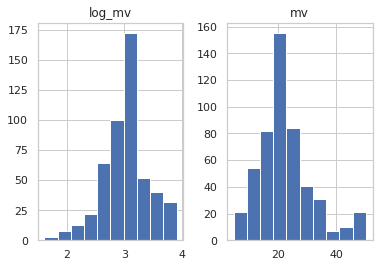

In [30]:
df_target.hist()

In [31]:
print(st.skew(df_target['log_mv']))
print(st.kurtosis(df_target['log_mv']))
print(st.skew(df_target['mv']))
print(st.kurtosis(df_target['mv']))

-0.33423125982999297
0.8078077428763462
1.1076159177373188
1.4900025601607387


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcfa8c294a8>,
      dtype=object)

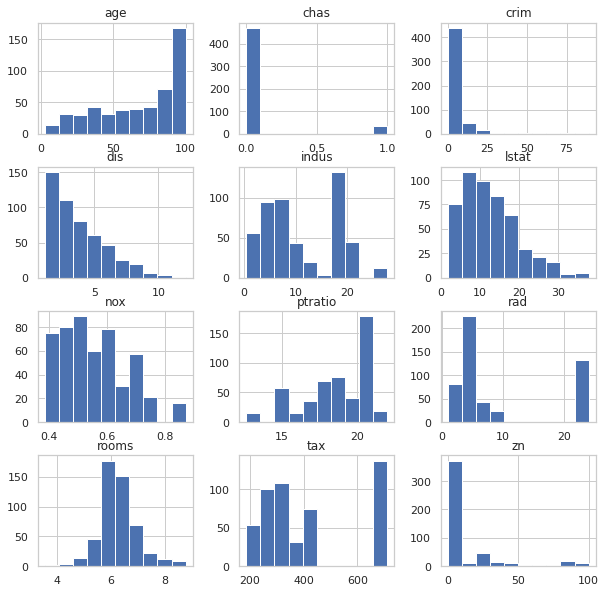

In [32]:
df_predictors.hist(figsize=(10,10))

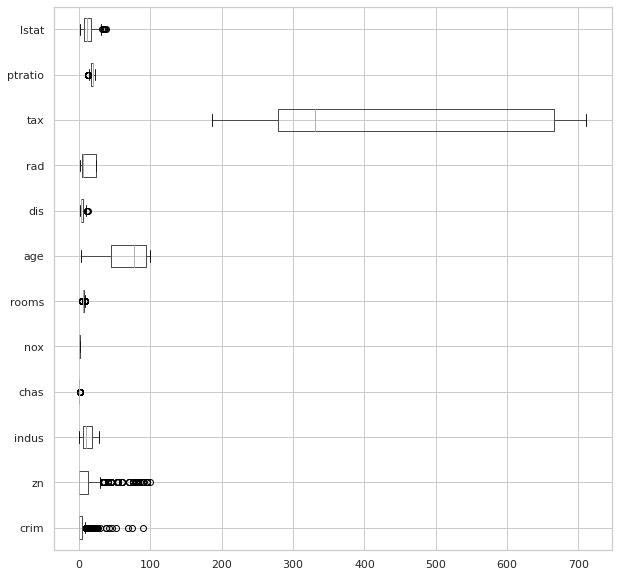

In [33]:
df_predictors.boxplot(vert=False, figsize=(10,10))

In [34]:
df_boxcox = df_predictors.apply(lambda x: x+.01)
df_boxcox = df_boxcox.transform(lambda x: st.boxcox(x)[0])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcfa8639518>,
      dtype=object)

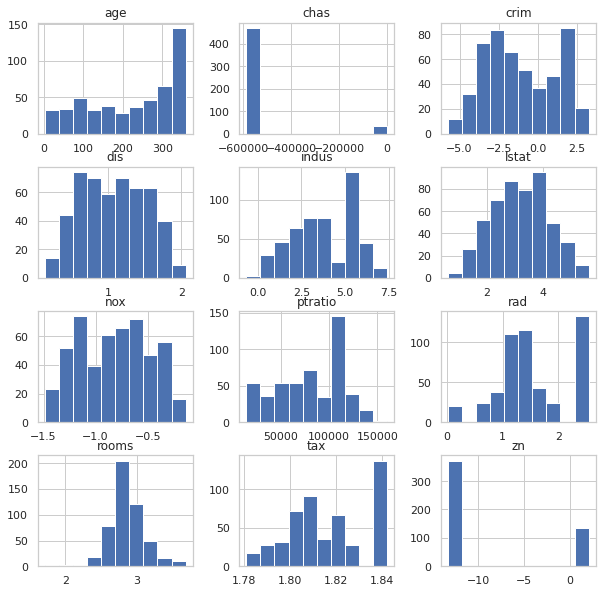

In [35]:
df_boxcox.hist(figsize=(10,10))

In [36]:
df_scaled = df_boxcox.transform(lambda x: (x - x.min()) / (x.max() - x.min()))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcfa7e4e518>,
      dtype=object)

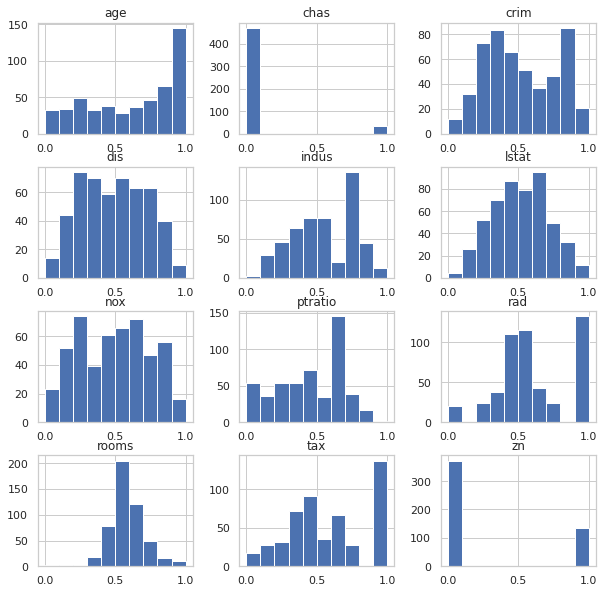

In [40]:
df_scaled.hist(figsize=(10,10))

In [37]:
df_merged = df_target.merge(df_scaled, left_index=True, right_index=True)

In [38]:
df_merged.columns

Index(['mv', 'log_mv', 'crim', 'zn', 'indus', 'chas', 'nox', 'rooms', 'age',
       'dis', 'rad', 'tax', 'ptratio', 'lstat'],
      dtype='object')

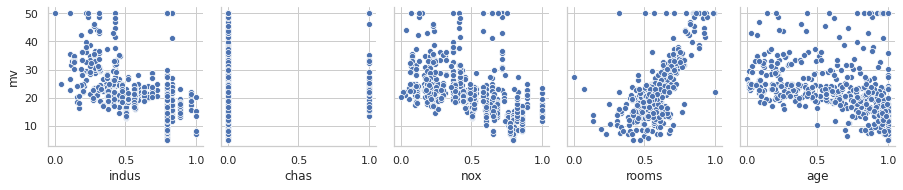

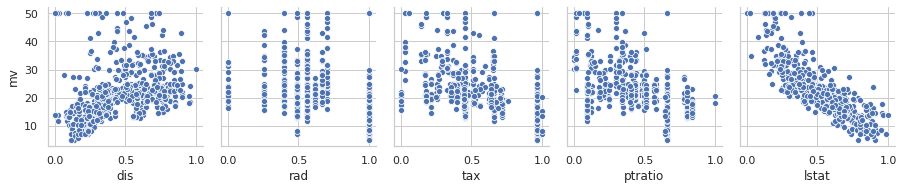

In [41]:
sns.pairplot(df_merged, y_vars=['mv'], x_vars=columns[2:7])
sns.pairplot(df_merged, y_vars=['mv'], x_vars=columns[7:12])

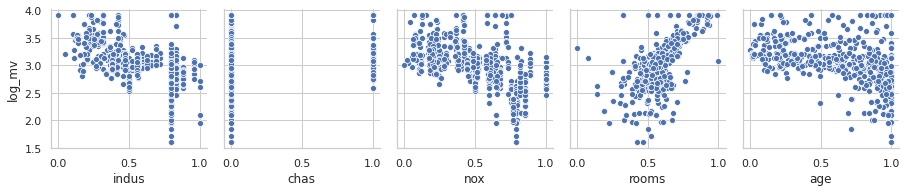

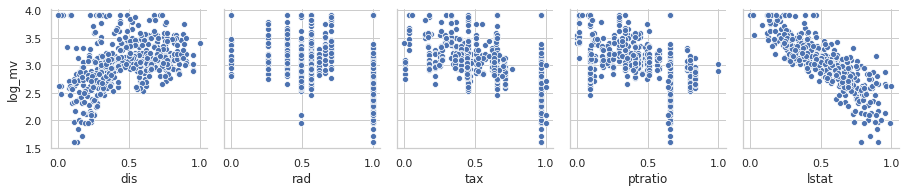

In [42]:
sns.pairplot(df_merged, y_vars=['log_mv'], x_vars=columns[2:7])
sns.pairplot(df_merged, y_vars=['log_mv'], x_vars=columns[7:12])

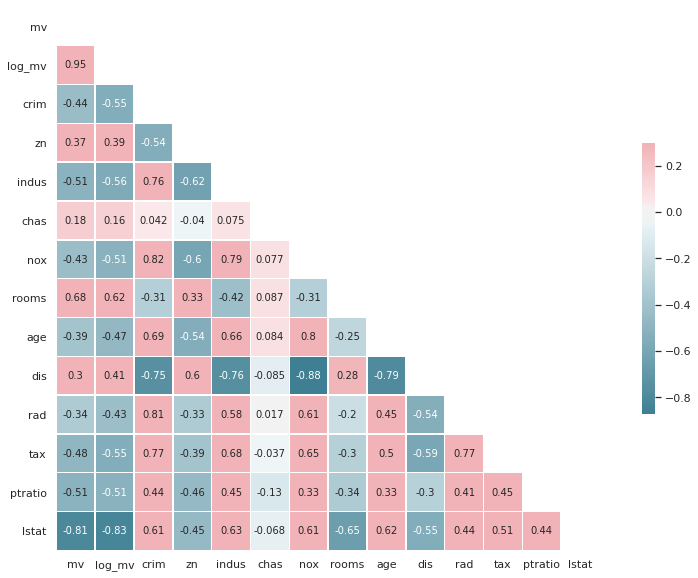

In [43]:
plt.figure(figsize=(15,10))
corr=df_merged.corr(method='pearson')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [154]:
X_train, X_test, y_train, y_test = train_test_split(df_scaled, df_target, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(404, 12) (404, 2)
(102, 12) (102, 2)


In [55]:
#Determine Predictors for Linear Regression Model
Y = y_train['mv']
X = X_train
linreg1 = sm.OLS(Y, X)

In [56]:
results = linreg1.fit()

In [57]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     mv   R-squared (uncentered):                   0.945
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                              563.1
Date:                Sun, 27 Sep 2020   Prob (F-statistic):                   1.37e-238
Time:                        04:43:24   Log-Likelihood:                         -1277.6
No. Observations:                 404   AIC:                                      2579.
Df Residuals:                     392   BIC:                                      2627.
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
crim           1.7045      3.051      0.559      0.577      -4.294       7.703
zn             1.7014      0.958      1.776      0.076      -0.182       3.585
indus          6.6962      2.375      2.819      0.005       2.026      11.367
chas           3.2330      1.170      2.762      0.006       0.932       5.534
nox            1.2235      2.828      0.433      0.665      -4.336       6.783
rooms         38.2548      2.339     16.352      0.000      33.655      42.854
age            4.5309      1.727      2.624      0.009       1.136       7.926
dis            7.2639      2.098      3.462      0.001       3.139      11.389
rad            5.2671      2.164      2.434      0.015       1.013       9.521
tax           -6.7764      1.885     -3.596      0.000     -10.482      -3.071
ptratio       -3.2214      1.553     -2.074      0.039      -6.275      -0.168
lstat        -19.3515      2.349     -8.238      0.000     -23.970     -14.733
==============================================================================
Omnibus:                      127.344   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              669.338
Skew:                           1.245   Prob(JB):                    4.52e-146
Kurtosis:                       8.793   Cond. No.                         23.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
Y = y_train['mv']
X2 = X_train.drop('nox', 1)
linreg2 = sm.OLS(Y, X2)
results = linreg2.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     mv   R-squared (uncentered):                   0.945
Model:                            OLS   Adj. R-squared (uncentered):              0.944
Method:                 Least Squares   F-statistic:                              615.6
Date:                Sun, 27 Sep 2020   Prob (F-statistic):                   5.93e-240
Time:                        04:49:56   Log-Likelihood:                         -1277.7
No. Observations:                 404   AIC:                                      2577.
Df Residuals:                     393   BIC:                                      2621.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
crim           2.0473      2.943      0.696      0.487      -3.739       7.834
zn             1.6723      0.954      1.752      0.081      -0.204       3.549
indus          6.9815      2.280      3.062      0.002       2.499      11.464
chas           3.2298      1.169      2.762      0.006       0.931       5.529
rooms         38.5816      2.212     17.443      0.000      34.233      42.930
age            4.7430      1.654      2.867      0.004       1.491       7.995
dis            6.9493      1.966      3.535      0.000       3.084      10.814
rad            5.2488      2.161      2.429      0.016       1.000       9.497
tax           -6.7135      1.877     -3.577      0.000     -10.404      -3.023
ptratio       -3.2800      1.546     -2.122      0.034      -6.319      -0.241
lstat        -19.1599      2.305     -8.314      0.000     -23.691     -14.629
==============================================================================
Omnibus:                      127.351   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              668.466
Skew:                           1.246   Prob(JB):                    6.99e-146
Kurtosis:                       8.788   Cond. No.                         20.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
Y = y_train['mv']
X3 = X_train.drop(['nox', 'crim'], 1)
linreg3 = sm.OLS(Y, X3)
results = linreg3.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     mv   R-squared (uncentered):                   0.945
Model:                            OLS   Adj. R-squared (uncentered):              0.944
Method:                 Least Squares   F-statistic:                              678.0
Date:                Sun, 27 Sep 2020   Prob (F-statistic):                   2.83e-241
Time:                        04:50:35   Log-Likelihood:                         -1278.0
No. Observations:                 404   AIC:                                      2576.
Df Residuals:                     394   BIC:                                      2616.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
zn             1.6209      0.951      1.704      0.089      -0.249       3.490
indus          7.3566      2.214      3.323      0.001       3.004      11.709
chas           3.2256      1.168      2.761      0.006       0.928       5.523
rooms         38.6935      2.205     17.552      0.000      34.359      43.028
age            4.9993      1.612      3.102      0.002       1.831       8.168
dis            6.6880      1.928      3.468      0.001       2.897      10.479
rad            6.0968      1.783      3.419      0.001       2.591       9.602
tax           -6.5017      1.851     -3.513      0.000     -10.141      -2.863
ptratio       -3.2808      1.545     -2.124      0.034      -6.318      -0.244
lstat        -18.9508      2.283     -8.299      0.000     -23.440     -14.462
==============================================================================
Omnibus:                      127.351   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              666.427
Skew:                           1.247   Prob(JB):                    1.94e-145
Kurtosis:                       8.777   Cond. No.                         19.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
Y = y_train['mv']
X4 = X_train.drop(['nox', 'crim', 'zn'], 1)
linreg4 = sm.OLS(Y, X4)
results = linreg4.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     mv   R-squared (uncentered):                   0.945
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                              749.4
Date:                Sun, 27 Sep 2020   Prob (F-statistic):                   4.26e-242
Time:                        04:52:08   Log-Likelihood:                         -1279.4
No. Observations:                 404   AIC:                                      2577.
Df Residuals:                     395   BIC:                                      2613.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
indus          6.4064      2.147      2.983      0.003       2.184      10.628
chas           3.2404      1.171      2.767      0.006       0.938       5.543
rooms         39.2318      2.187     17.938      0.000      34.932      43.531
age            4.9115      1.615      3.042      0.003       1.737       8.086
dis            7.8502      1.808      4.342      0.000       4.295      11.405
rad            6.2999      1.783      3.533      0.000       2.794       9.806
tax           -6.1032      1.841     -3.316      0.001      -9.722      -2.485
ptratio       -4.0608      1.479     -2.746      0.006      -6.968      -1.153
lstat        -18.7400      2.286     -8.199      0.000     -23.233     -14.247
==============================================================================
Omnibus:                      133.772   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              737.691
Skew:                           1.301   Prob(JB):                    6.49e-161
Kurtosis:                       9.087   Cond. No.                         19.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [98]:
#Use linreg4 to fit linear model in sklearn
Y = y_train['mv']
X4 = X_train.drop(['nox', 'crim', 'zn'], 1)

lrm_mv = LinearRegression()

# Fit data on to the model
lrm_mv.fit(X4, Y)

# Predict
y_predicted_lrm = lrm_mv.predict(X_test.drop(['nox', 'crim', 'zn'], 1))

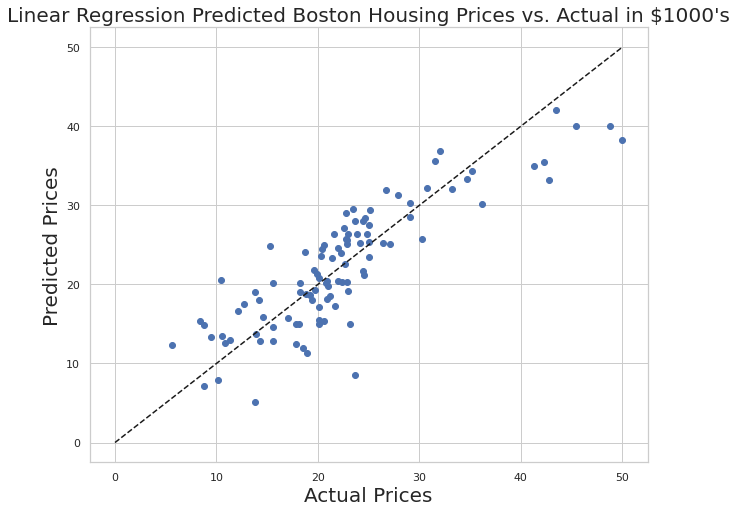

In [65]:
plt.figure(figsize=(10,8))
plt.scatter(y_test['mv'], y_predicted_lrm)
plt.plot([0, 50], [0, 50], '--k')
plt.axis('tight')
plt.ylabel('Predicted Prices', fontsize=20);
plt.xlabel('Actual Prices', fontsize=20);
plt.title("Linear Regression Predicted Boston Housing Prices vs. Actual in $1000's", fontsize=20)

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

plt.show()

In [99]:
X = X_test.drop(['nox', 'crim', 'zn'], 1)
Y = y_test['mv']
print("Linear Regression R_squared = ",lrm_mv.score(X, Y)) 
pred= lrm_mv.predict(X)
rmse = sqrt(mean_squared_error(pred, Y))
print('Linear Regression RMSE = ', rmse)

Linear Regression R_squared =  0.7241036727059484
Linear Regression RMSE =  4.518933497740054


In [111]:
#Ridge Regression Model
rrm_mv = Ridge()

# Fit data on to the model
rrm_mv.fit(X_train, y_train['mv'])

# Predict
y_predicted_rrm = rrm_mv.predict(X_test)

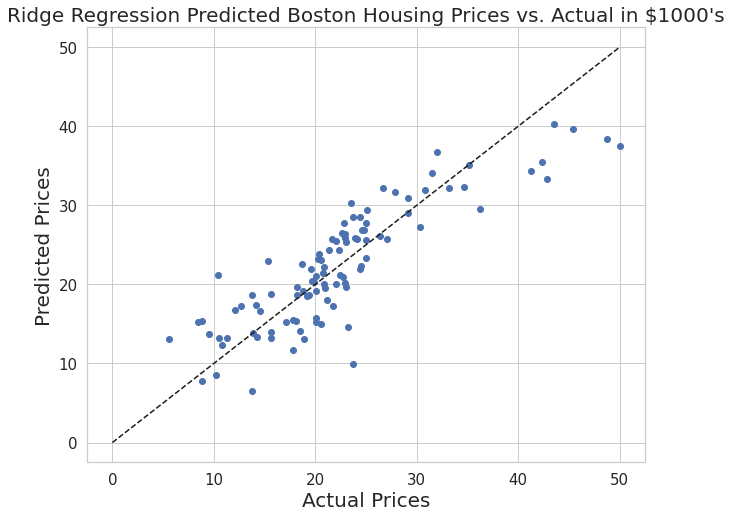

In [104]:
plt.figure(figsize=(10,8))
plt.scatter(y_test['mv'], y_predicted_rrm)
plt.plot([0, 50], [0, 50], '--k')
plt.axis('tight')
plt.ylabel('Predicted Prices', fontsize=20);
plt.xlabel('Actual Prices', fontsize=20);
plt.title("Ridge Regression Predicted Boston Housing Prices vs. Actual in $1000's", fontsize=20)

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

plt.show()

In [105]:
X = X_test
Y = y_test['mv']

print("Ridge Regression R_squared = ",rrm_mv.score(X,Y)) 
pred= rrm_mv.predict(X)
rmse = sqrt(mean_squared_error(pred, Y))
print('Ridge Regression RMSE = ', rmse)

Ridge Regression R_squared =  0.7400406607525095
Ridge Regression RMSE =  4.386475446742318


In [73]:
#Lasso Regression
larm_mv = Lasso(alpha=0.001)

# Fit data on to the model
larm_mv.fit(X_train, y_train['mv'])

# Predict
y_predicted_larm = larm_mv.predict(X_test)

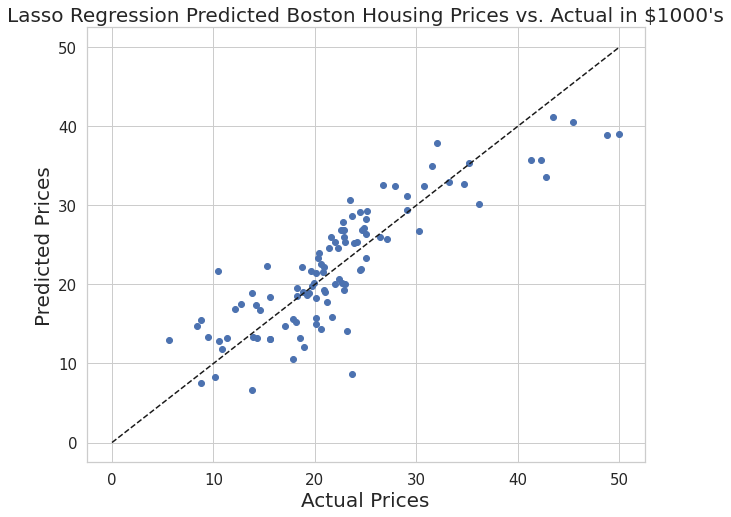

In [74]:
plt.figure(figsize=(10,8))
plt.scatter(y_test['mv'],y_predicted_larm)
plt.plot([0, 50], [0, 50], '--k')
plt.axis('tight')
plt.ylabel('Predicted Prices', fontsize=20);
plt.xlabel('Actual Prices', fontsize=20);
plt.title("Lasso Regression Predicted Boston Housing Prices vs. Actual in $1000's", fontsize=20)

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

plt.show()

In [76]:
X = X_test
Y = y_test['mv']

print("Lasso Regression R_squared = ",larm_mv.score(X,Y)) 
pred= larm_mv.predict(X)
rmse = sqrt(mean_squared_error(pred, Y))
print('Lasso Regression RMSE = ', rmse)

Lasso Regression R_squared =  0.7284117998438817
Lasso Regression RMSE =  4.483513058653556


In [155]:
#Elastic Net
enrm_mv = ElasticNet(alpha=0.001)

# Fit data on to the model
enrm_mv.fit(X_train, y_train['mv'])

# Predict
y_predicted_enrm = enrm_mv.predict(X_test)

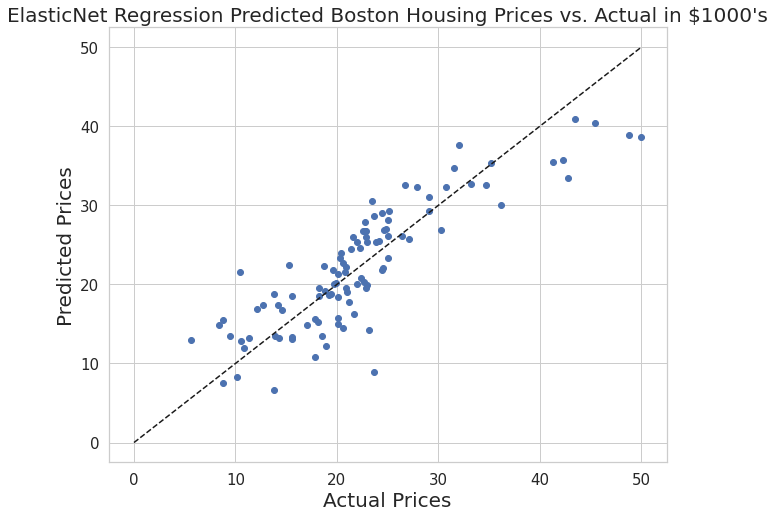

In [78]:
plt.figure(figsize=(10,8))
plt.scatter(y_test['mv'], y_predicted_enrm)
plt.plot([0, 50], [0, 50], '--k')
plt.axis('tight')
plt.ylabel('Predicted Prices', fontsize=20);
plt.xlabel('Actual Prices', fontsize=20);
plt.title("ElasticNet Regression Predicted Boston Housing Prices vs. Actual in $1000's", fontsize=20)

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

plt.show()

In [79]:
print("ElasticNet Regression R_squared = ",enrm_mv.score(X,Y)) 
pred= enrm_mv.predict(X)
rmse = sqrt(mean_squared_error(pred, Y))
print('ElasticNet Regression RMSE = ', rmse)

ElasticNet Regression R_squared =  0.7317235517798774
ElasticNet Regression RMSE =  4.456093188770574


In [80]:
#Use linreg4 to fit linear model on log mv
Y = y_train['log_mv']
lrm_log = LinearRegression()

# Fit data on to the model
lrm_log.fit(X4, Y)

# Predict
y_predicted_lrm = lrm_log.predict(X_test.drop(['nox', 'crim', 'zn'], 1))

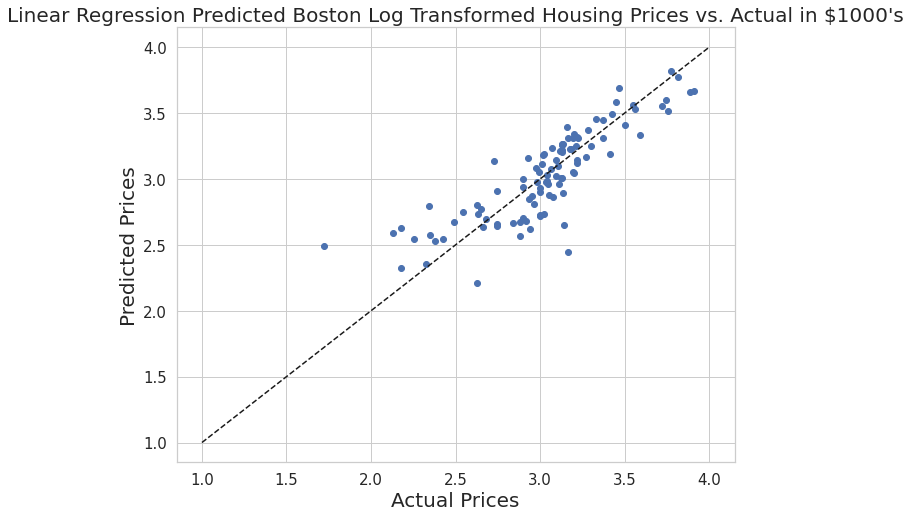

In [85]:
plt.figure(figsize=(10,8))
plt.scatter(y_test['log_mv'], y_predicted_lrm)
plt.plot([1, 4], [1, 4], '--k')
plt.axis('tight')
plt.ylabel('Predicted Prices', fontsize=20);
plt.xlabel('Actual Prices', fontsize=20);
plt.title("Linear Regression Predicted Boston Log Transformed Housing Prices vs. Actual in $1000's", fontsize=20)

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

plt.show()

In [86]:
X = X_test.drop(['nox', 'crim', 'zn'], 1)
Y = y_test['log_mv']
print("Linear Regression R_squared = ",lrm_log.score(X, Y)) 
pred= lrm_log.predict(X)
rmse = sqrt(mean_squared_error(pred, Y))
print('Linear Regression RMSE = ', rmse)

Linear Regression R_squared =  0.7160185982283483
Linear Regression RMSE =  0.20931775602144664


In [116]:
#Ridge Regression Model
rrm_log = Ridge()

# Fit data on to the model
rrm_log.fit(X_train, y_train['log_mv'])

# Predict
y_predicted_rrm = rrm_log.predict(X_test)

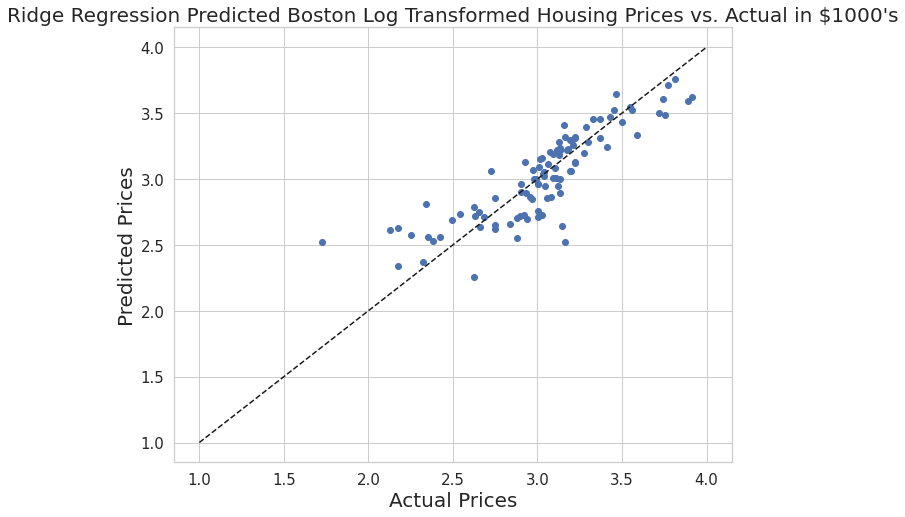

In [88]:
plt.figure(figsize=(10,8))
plt.scatter(y_test['log_mv'], y_predicted_rrm)
plt.plot([1, 4], [1, 4], '--k')
plt.axis('tight')
plt.ylabel('Predicted Prices', fontsize=20);
plt.xlabel('Actual Prices', fontsize=20);
plt.title("Ridge Regression Predicted Boston Log Transformed Housing Prices vs. Actual in $1000's", fontsize=20)

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

plt.show()

In [90]:
X = X_test
Y = y_test['log_mv']
print("Ridge Regression R_squared = ",rrm_log.score(X, Y)) 
pred= rrm_log.predict(X)
rmse = sqrt(mean_squared_error(pred, Y))
print('Ridge Regression RMSE = ', rmse)

Ridge Regression R_squared =  0.7309607736428856
Ridge Regression RMSE =  0.2037365387394751


In [91]:
#Lasso Regression
larm_log = Lasso(alpha=0.001)

# Fit data on to the model
larm_log.fit(X_train, y_train['log_mv'])

# Predict
y_predicted_larm = larm_log.predict(X_test)

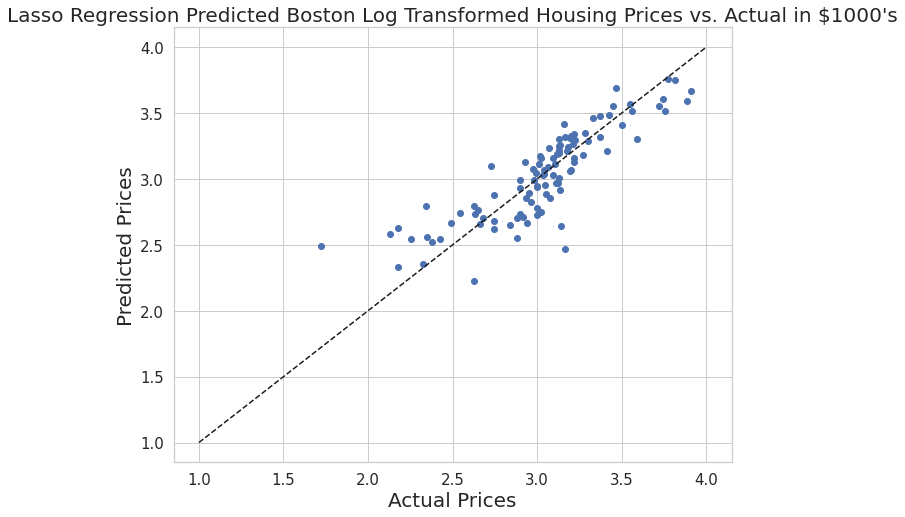

In [93]:
plt.figure(figsize=(10,8))
plt.scatter(y_test['log_mv'],y_predicted_larm)
plt.plot([1, 4], [1, 4], '--k')
plt.axis('tight')
plt.ylabel('Predicted Prices', fontsize=20);
plt.xlabel('Actual Prices', fontsize=20);
plt.title("Lasso Regression Predicted Boston Log Transformed Housing Prices vs. Actual in $1000's", fontsize=20)

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

plt.show()

In [94]:
X = X_test
Y = y_test['log_mv']
print("Lasso Regression R_squared = ",larm_log.score(X, Y)) 
pred= larm_log.predict(X)
rmse = sqrt(mean_squared_error(pred, Y))
print('Lasso Regression RMSE = ', rmse)

Lasso Regression R_squared =  0.7290590707985203
Lasso Regression RMSE =  0.204455326300296


In [156]:
#Elastic Net
enrm_log = ElasticNet(alpha=0.001)

# Fit data on to the model
enrm_log.fit(X_train, y_train['log_mv'])

# Predict
y_predicted_enrm = enrm_log.predict(X_test)

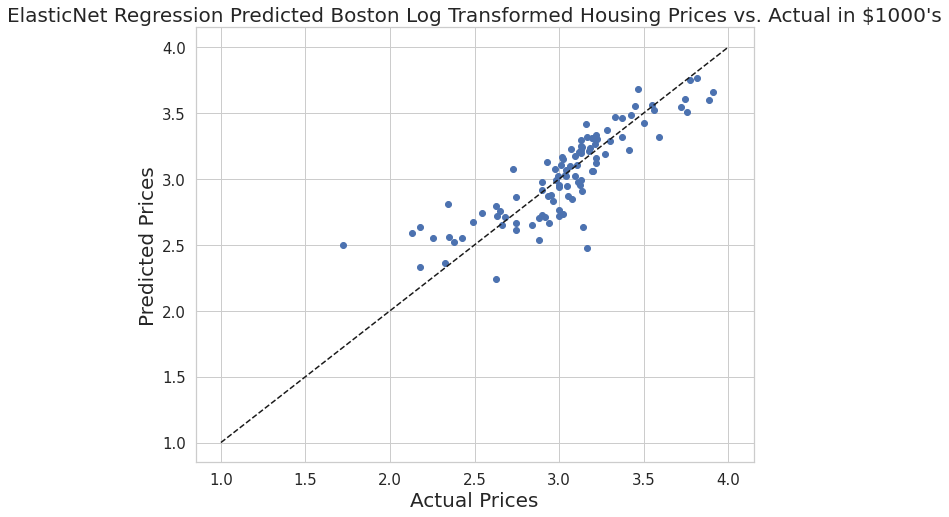

In [96]:
plt.figure(figsize=(10,8))
plt.scatter(y_test['log_mv'], y_predicted_enrm)
plt.plot([1, 4], [1, 4], '--k')
plt.axis('tight')
plt.ylabel('Predicted Prices', fontsize=20);
plt.xlabel('Actual Prices', fontsize=20);
plt.title("ElasticNet Regression Predicted Boston Log Transformed Housing Prices vs. Actual in $1000's", fontsize=20)

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

plt.show()

In [97]:
X = X_test
Y = y_test['log_mv']
print("Elastic Net Regression R_squared = ",enrm_log.score(X, Y)) 
pred= enrm_log.predict(X)
rmse = sqrt(mean_squared_error(pred, Y))
print('Elastic Net Regression RMSE = ', rmse)

Elastic Net Regression R_squared =  0.7274460383473884
Elastic Net Regression RMSE =  0.20506303012972077


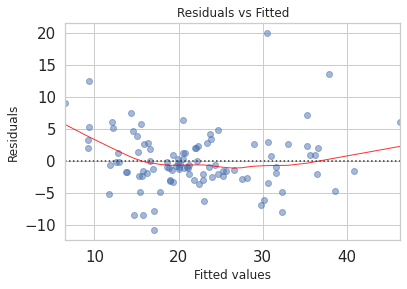

In [157]:
# model values
model_fitted_y = enrm_mv.predict(X_test)
# model residuals
model_residuals = (y_test['mv'] - model_fitted_y)

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, y_test['mv'], data=y_test,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

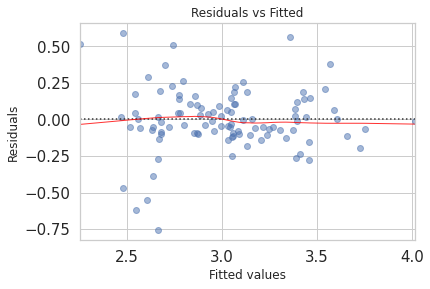

In [158]:
# model values
model_fitted_y = enrm_log.predict(X_test)
# model residuals
model_residuals = (y_test['log_mv'] - model_fitted_y)

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, y_test['log_mv'], data=y_test,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

In [141]:
#K Folds
#mv = df_target['mv']
#log = df_target['log_mv']
model_data_mv = df_merged.drop('log_mv', 1).values
model_data_log = df_merged.drop('mv', 1).values

In [142]:
# Seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

# The model input data outside of the modeling method calls
names = ['Linear_Regression', 'Ridge_Regression', 'Lasso_Regression', 'ElasticNet_Regression']

# Specify the set of regression models being evaluated (we set normalize=False because we have standardized above)
regressors = [LinearRegression(fit_intercept = True, normalize = False), 
              Ridge(alpha = 75, solver = 'cholesky', fit_intercept = True, normalize = False, random_state = RANDOM_SEED),
              Lasso(alpha = 0.01, max_iter=10000, tol=0.01, fit_intercept = True, normalize = False, random_state = RANDOM_SEED),
              ElasticNet(alpha = 0.01, l1_ratio = 0.5, max_iter=10000, tol=0.01, fit_intercept = True, normalize = False, random_state = RANDOM_SEED),
              ]

In [143]:
# Establish number of cross folds employed for cross-validation
N_FOLDS = 10

# Setup numpy array for storing results
cv_results = np.zeros((N_FOLDS, len(names)))

# Initiate splitting process
kf = KFold(n_splits = N_FOLDS, shuffle=False, random_state = RANDOM_SEED)

# Check the splitting process by looking at fold observation counts
index_for_fold = 0  # Fold count initialized 
for train_index, test_index in kf.split(model_data_mv):
    print('\nFold index:', index_for_fold, '---------------------------------------------------------------------------------------')

# The structure of modeling data for this study has the response variable coming first and explanatory variables later          
# so 1:model_data_mv.shape[1] slices for explanatory variables and 0 is the index for the response variable    
    X_train = model_data_mv[train_index, 1:model_data_mv.shape[1]]
    X_test = model_data_mv[test_index, 1:model_data_mv.shape[1]]
    y_train = model_data_mv[train_index, 0]
    y_test = model_data_mv[test_index, 0]   

    index_for_method = 0  # Method count initialized
    for name, reg_model in zip(names, regressors):
        reg_model.fit(X_train, y_train)  # Fit on the train set for this fold
 
        # Evaluate on the test set for this fold
        y_test_predict = reg_model.predict(X_test)
        fold_method_result = sqrt(mean_squared_error(y_test, y_test_predict))
        cv_results[index_for_fold, index_for_method] = fold_method_result
        index_for_method += 1
  
    index_for_fold += 1

cv_results_df = pd.DataFrame(cv_results)
cv_results_df.columns = names

print('\n---------------------------------------------------------------------------------------')
print('Average results from ', N_FOLDS, '-fold cross-validation\n',
      'in standardized units (mean 0, standard deviation 1)\n',
      '\nMethod               Root mean-squared error', sep = '')    
print(cv_results_df.mean())


Fold index: 0 ---------------------------------------------------------------------------------------

Fold index: 1 ---------------------------------------------------------------------------------------

Fold index: 2 ---------------------------------------------------------------------------------------

Fold index: 3 ---------------------------------------------------------------------------------------

Fold index: 4 ---------------------------------------------------------------------------------------

Fold index: 5 ---------------------------------------------------------------------------------------

Fold index: 6 ---------------------------------------------------------------------------------------

Fold index: 7 ---------------------------------------------------------------------------------------

Fold index: 8 ---------------------------------------------------------------------------------------

Fold index: 9 ----------------------------------------------------------

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [144]:
cv_results_df.head(10)

,Linear_Regression,Ridge_Regression,Lasso_Regression,ElasticNet_Regression
0,3.407006,4.862245,3.373476,2.403339
1,3.621459,4.770453,3.592566,3.383278
2,3.052981,3.186556,2.956300,2.839064
3,5.117444,10.847896,5.250383,5.834271
4,4.920694,8.498521,4.998502,5.068108
5,5.019375,9.629726,5.198657,5.413138
6,3.231042,4.447127,3.372028,3.431134
7,10.577444,11.192469,10.540233,9.734936
8,4.878307,6.550763,4.877836,4.945187
9,4.757324,3.486155,4.638069,4.094908


In [145]:
# Establish number of cross folds employed for cross-validation
N_FOLDS = 10

# Setup numpy array for storing results
cv_results = np.zeros((N_FOLDS, len(names)))

# Initiate splitting process
kf = KFold(n_splits = N_FOLDS, shuffle=False, random_state = RANDOM_SEED)

# Check the splitting process by looking at fold observation counts
index_for_fold = 0  # Fold count initialized 
for train_index, test_index in kf.split(model_data_log):
    print('\nFold index:', index_for_fold, '---------------------------------------------------------------------------------------')

# The structure of modeling data for this study has the response variable coming first and explanatory variables later          
# so 1:model_data_log.shape[1] slices for explanatory variables and 0 is the index for the response variable    
    X_train = model_data_log[train_index, 1:model_data_log.shape[1]]
    X_test = model_data_log[test_index, 1:model_data_log.shape[1]]
    y_train = model_data_log[train_index, 0]
    y_test = model_data_log[test_index, 0]   

    index_for_method = 0  # Method count initialized
    for name, reg_model in zip(names, regressors):
        reg_model.fit(X_train, y_train)  # Fit on the train set for this fold
 
        # Evaluate on the test set for this fold
        y_test_predict = reg_model.predict(X_test)
        fold_method_result = sqrt(mean_squared_error(y_test, y_test_predict))
        cv_results[index_for_fold, index_for_method] = fold_method_result
        index_for_method += 1
  
    index_for_fold += 1

cv_results_df = pd.DataFrame(cv_results)
cv_results_df.columns = names

print('\n---------------------------------------------------------------------------------------')
print('Average results from ', N_FOLDS, '-fold cross-validation\n',
      'in standardized units (mean 0, standard deviation 1)\n',
      '\nMethod               Root mean-squared error', sep = '')    
print(cv_results_df.mean())


Fold index: 0 ---------------------------------------------------------------------------------------

Fold index: 1 ---------------------------------------------------------------------------------------

Fold index: 2 ---------------------------------------------------------------------------------------

Fold index: 3 ---------------------------------------------------------------------------------------

Fold index: 4 ---------------------------------------------------------------------------------------

Fold index: 5 ---------------------------------------------------------------------------------------

Fold index: 6 ---------------------------------------------------------------------------------------

Fold index: 7 ---------------------------------------------------------------------------------------

Fold index: 8 ---------------------------------------------------------------------------------------

Fold index: 9 ----------------------------------------------------------

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [146]:
cv_results_df.head(10)

,Linear_Regression,Ridge_Regression,Lasso_Regression,ElasticNet_Regression
0,0.131737,0.201552,0.130559,0.120977
1,0.136207,0.169072,0.131020,0.122371
2,0.174264,0.127601,0.133119,0.136063
3,0.155589,0.365460,0.210459,0.198953
4,0.188219,0.292164,0.217468,0.191182
5,0.213232,0.318941,0.232717,0.208168
6,0.156545,0.172659,0.182674,0.163385
7,0.470959,0.565135,0.444848,0.466852
8,0.290369,0.404964,0.309537,0.315844
9,0.285804,0.235703,0.203960,0.216543
